In [1]:
# 라이브러리 불러오기
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
# 데이터 셋 변수
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [3]:
# 데이터셋 다운로드 및 압축풀기
%%capture
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz
!tar -zxvf facades.tar.gz -C ./

In [4]:
# 데이터셋 개수 출력(학습/평가/테스트)
print("학습 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/train/'))[2]))
print("평가 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/val/'))[2]))
print("테스트 데이터셋 A와 B의 개수:", len(next(os.walk('./facades/test/'))[2]))

학습 데이터셋 A와 B의 개수: 400
평가 데이터셋 A와 B의 개수: 100
테스트 데이터셋 A와 B의 개수: 106


이미지 크기: (512, 256)


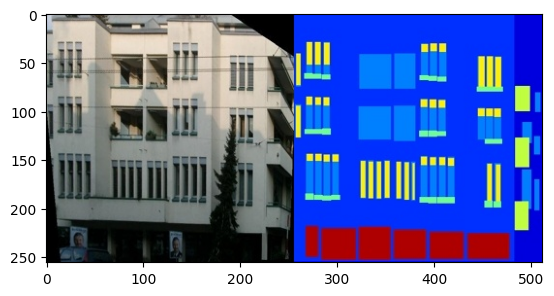

In [5]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('./facades/train/1.jpg')

# 이미지 크기는 256 X 256 크기 2개를 이어붙인 형태
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [6]:
# 데이터의 개수가 적기 때문에 학습 데이터셋과 테스트 데이터 셋을 모두 학습 시기에 사용한다.
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.jpg")) # jpg 파일을 이름순으로 files 변수에 담아준다.
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.jpg"))) # Test 데이터셋 또한 동일

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]) # 이미지를 읽어온다
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반(실제 사진)
        img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반(제공 데이터 사진)

        # 데이터 증진(data augmentation)을 위한 좌우 반전(horizontal flip)
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [7]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC), # 이미지 크기를 256x256으로 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("facades", transforms_=transforms_)
val_dataset = ImageDataset("facades", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# 생성자 판별자를 위한 기본적인 모듈 정의
# U-Net 아키텍처 다운 샘플링
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처 업 샘플링 Skip Connection 입력 활용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    # 모델 출력값을 skip_input으로 받아서 사용
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)
        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    # rgb color '3'
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        # convolution layer를 거친다.
        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        # x, y 중간지점 512 x 1 x 1형성
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]


        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        # Skip Connection을 사용하기 때문에, 출력 채널의 크기 x 2가 다음 입력 채널의 크기가 된다.
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            # 3 X 256 X 256의 입력이미지와 동일한 차원의 출력 이미지를 만든다.
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # d8: 512 X 1 X 1 즉 인코더 디코더 중앙의 블럭 출력값
        # d7: 중앙 전 인코더 마지막 출력값
        # u1의 매개변수: d8은 Up 샘플링 one 블럭을 거쳐서처리가 되고, d7이 그대로 채널 레벨로 연결되어 u1에 담긴다.
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
# 너비와 높이가 2배씩 감소하면서 채널값은 커지는 형태로 일반적인 convolution과 동일
# 다만, conditional Gan이기에 입력 조건(x) 이미지와 정답 이미지(y)가 같이 들어와야한다.
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        # convolution연산 수행
        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소하면서 채널값은 커지는 형태로 일반적인 convolution과 동일
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [12]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    # conv layer를 적절한 파라메터 값으로 초기화
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    # batch normalization layer를 적절한 파라메터 값으로 초기화
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:
import time

n_epochs = 20 # 학습횟수 20
sample_interval = 200 # 200번 배치마다 결과 출력

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        # 그림을 사진으로 바꿔주는 task 수행
        real_A = batch["B"].cuda() # 가짜(그림)
        real_B = batch["A"].cuda() # 진짜(사진)

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너비와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습. """
        optimizer_G.zero_grad()

        # 이미지 생성(그림을 넣어서 사진이미지 생성)
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        # 그림 이미지, 생성 이미지가 들어왔을 때 진짜 이미지로 분류될 수 있도록 생성자를 학습한다.
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        # 실제 이미지를 실제라고 학습시키고
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        # 가짜 이미지에 대해서는 fake로 분류
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i

        # 특정 인터벌 마다 이미지 파일로 저장
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-13-b8eff7555a41>:19: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1


[Epoch 0/20] [D loss: 0.384002] [G pixel loss: 0.337317, adv loss: 0.5302278995513916] [Elapsed time: 27.18s]
[Epoch 1/20] [D loss: 0.534946] [G pixel loss: 0.382329, adv loss: 0.8259389400482178] [Elapsed time: 50.38s]
[Epoch 2/20] [D loss: 0.117970] [G pixel loss: 0.324641, adv loss: 1.0534663200378418] [Elapsed time: 73.09s]
[Epoch 3/20] [D loss: 0.180572] [G pixel loss: 0.338599, adv loss: 0.5557450652122498] [Elapsed time: 96.70s]
[Epoch 4/20] [D loss: 0.118394] [G pixel loss: 0.345379, adv loss: 0.8905395865440369] [Elapsed time: 119.54s]
[Epoch 5/20] [D loss: 0.104630] [G pixel loss: 0.369545, adv loss: 0.8640536069869995] [Elapsed time: 142.56s]
[Epoch 6/20] [D loss: 0.078235] [G pixel loss: 0.363758, adv loss: 0.9855546951293945] [Elapsed time: 165.80s]
[Epoch 7/20] [D loss: 0.049367] [G pixel loss: 0.330810, adv loss: 1.007735252380371] [Elapsed time: 189.58s]
[Epoch 8/20] [D loss: 0.143920] [G pixel loss: 0.326034, adv loss: 1.3015880584716797] [Elapsed time: 212.45s]
[Epoch

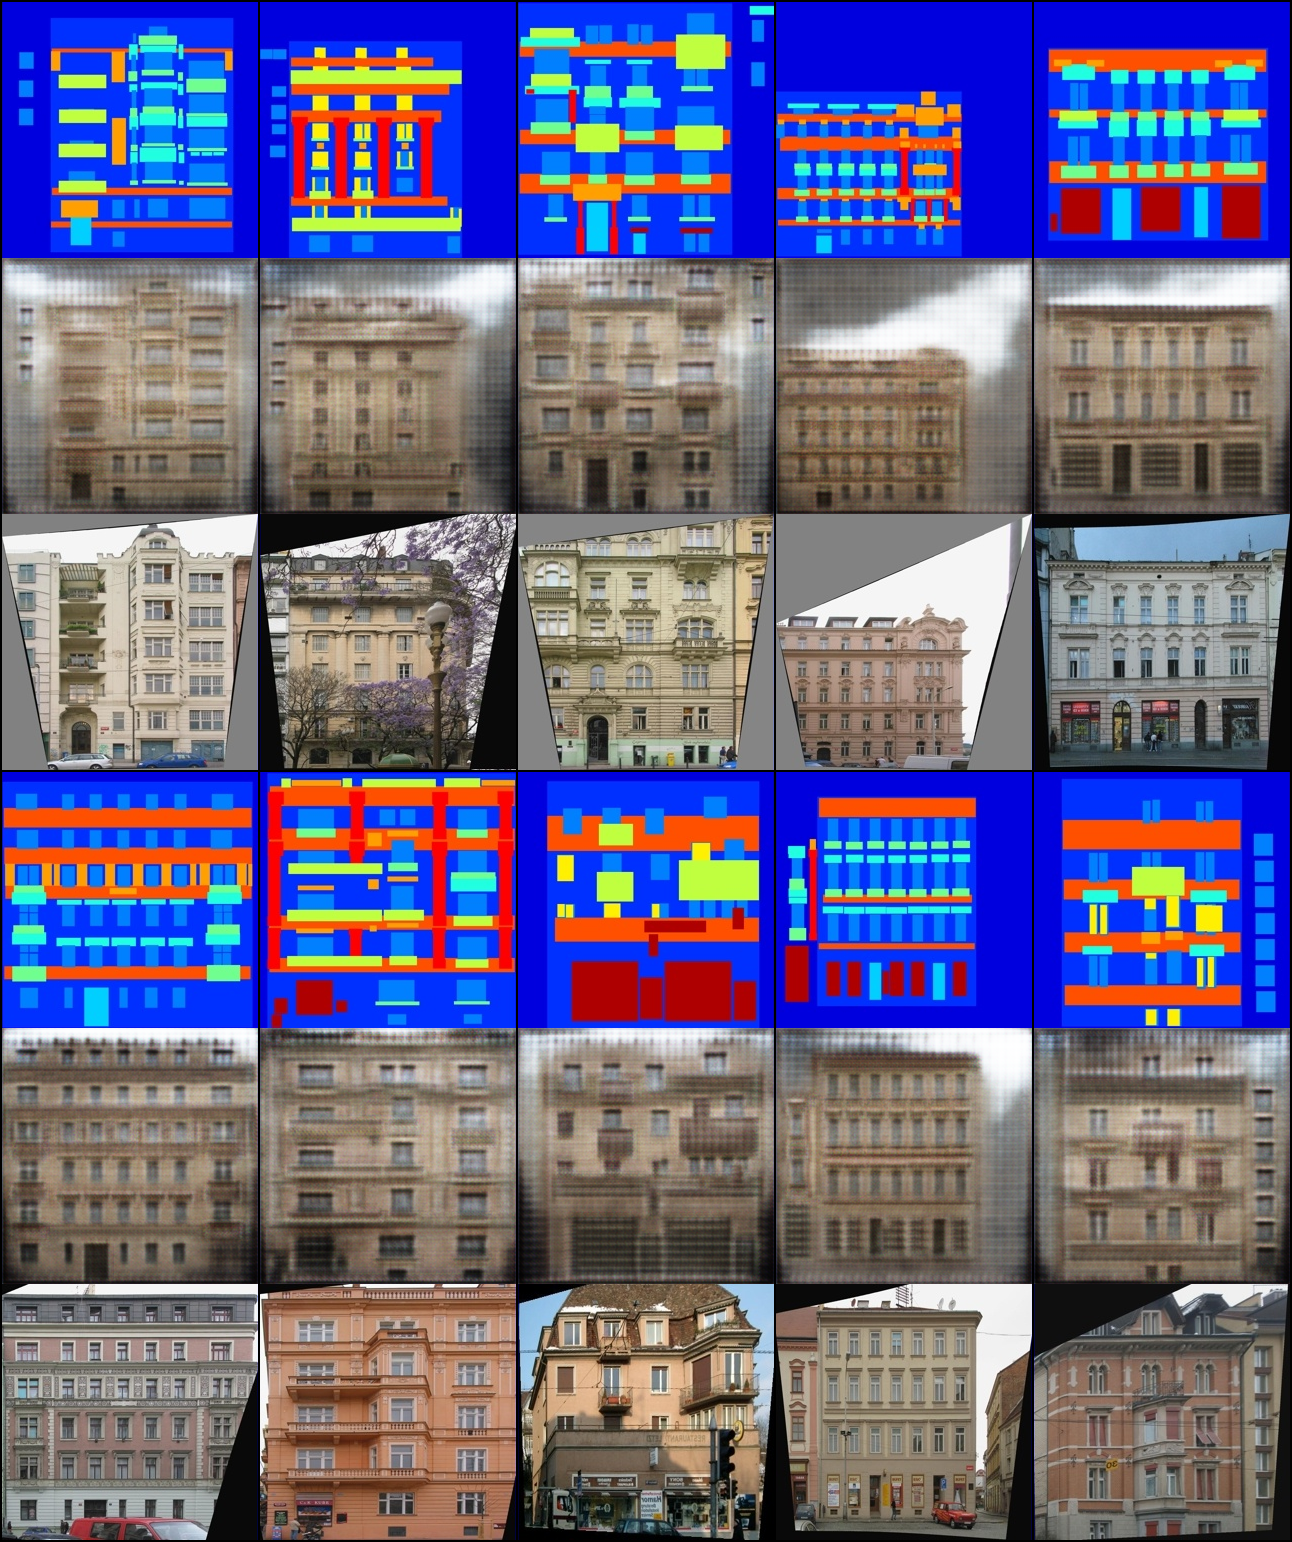

In [14]:
from IPython.display import Image

Image('1000.png')